In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA, TruncatedSVD

from dataclasses import dataclass
from typing import Any, Dict, Iterable, List, Optional, Tuple, Union, Optional
import pyodbc

import math
import re
import warnings

print("hello world")

hello world


In [47]:
# read xlsx into pandas
df = pd.read_excel("../isec_data/df_sample_100k.xlsx", engine="openpyxl", index_col=0)
df.iloc[:10]

,serial_no,acct_opn_dt,name,dob,age,gender,marital_status,email,city,state,...,iai_uccstatus_dt,iai_class_download_run_no,iai_modify_dt_run_no,iai_enable_for_dwid,iai_bnk_account_flag,iai_comm_class_status,iai_bank_type,iai_ifsc_cd,iai_bnk_account_flag_changed_dt,match_id
0,9007305054,2017-08-19,SHARAD SINGH,1995-02-02,31,M,Y,95ssharda@gmail.com,RAE BARELI,UTTAR PRADESH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504297e+09
1,9007305091,2017-08-18,HIRDESH SINGH,1944-02-10,82,F,M,singhvikekkumar@gmail.com,EAST DELHI,DELHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504296e+09
2,9007305145,2017-10-07,NIRANJAN KUMAR,1990-02-15,36,M,N,niranjankumar.singh2@gmail.com,DELHI,DELHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504359e+09
3,9007305200,2017-07-18,ABHISHEK SHARMA,1997-09-20,28,M,Y,abhishekkharma1997@gmail.com,FARIDABAD,HARYANA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504258e+09
4,9007305236,2017-08-09,ASHOK KUMAR LAVANIA,1946-12-27,79,M,Y,alavania27@gmail.com,DELHI,DELHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504289e+09
5,9007305538,2017-06-02,SURUCHI GUPTA,1988-02-23,38,F,Y,suruchibansal2388@gmail.com,NOIDA,UTTAR PRADESH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504207e+09
6,9007305651,2017-06-27,SHORBAN BANERJEE,1971-12-28,54,F,Y,shorban.banerjee@gmail.com,NOIDA,UTTAR PRADESH,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504231e+09
7,9007305877,2017-08-01,SANJEEV GHOSH,1970-03-24,56,M,Y,sanjeev@whitehouseoverseas.com,DELHI,DELHI,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504274e+09
8,9007306867,2017-10-05,NIDHI BEMBI,1994-09-14,31,F,N,bembindhi@gmail.com,LUDHIANA,PUNJAB,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504355e+09
9,9007307094,2017-07-25,RUCHI PUNEET GUPTA,1986-06-01,40,F,Y,ruchi.skyblue@gmail.com,DHULE,MAHARASHTRA,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.504266e+09


In [48]:
# transform income
df["income"] = df["income_desc"].apply(
    lambda v: (
        int(int(m.group(1)) + int(m.group(2)) / 2)
        if pd.notna(v) and (m := re.search(r"(\d+)\s*LAC\s*TO\s*(\d+)\s*LAC", v, re.I))
        else None
    )
)

# convert datetimes
df_clean = df.loc[:, ~df.columns.to_series().map(lambda c: pd.api.types.is_datetime64_any_dtype(df[c]))].copy()
# drop any columns with all nulls
df_clean = df_clean.dropna(axis=1, how='all')
# drop PII etc.
df_clean = df_clean.drop(columns=["serial_no", "name", "email", "city", "state", "country", "pincode", "income_desc", "sourcing_team", "sourcing_channel", "iaf_publisher", "advisory_team", "dnd_flag", "dnc_flag", "neq_total_assets_million", "peak_asset_val_million", "vertical", "mobile_number", "pan", "bsp_flag", "bank_flag", "ers_mapped", "match_id"], errors="coerce")

df_clean[:10]

,age,gender,marital_status,education_desc,occupation_desc,ri_flag,nri_flag,mf_vertical,eq_vertical,no_of_logins,...,allocated_amt,brokerage_type,grade,scheme_code,brokerage_rate,brkg_type,mtf_brkg,income_segment,pincode_affluence,income
0,31,M,Y,GRADUATE,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,28.0,...,NaN,MSAVER,D,Special,29.0,High,High,PB,Low,3.0
1,82,F,M,OTHERS,HOUSEWIFE,Y,N,VIRTUAL RM,SELECT,1711.0,...,NaN,FPRMN1001,A,Special,10.0,Low,Low,WM,Very High,3.0
2,36,M,N,OTHERS,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,765.0,...,1.0,EMP07007N,B,Special,NaN,NaN,NaN,PB,Very High,10.0
3,28,M,Y,OTHERS,PROFESSIONAL,Y,N,ONLINE,ONLINE,45.0,...,4778.0,MSAVER,B,Special,29.0,High,High,WM,Very High,3.0
4,79,M,Y,GRADUATE,PRIVATE SECTOR,Y,N,PWM-PHYSICAL,WEALTH,742.0,...,189.0,APRM07007,A,Special,7.0,Low,Low,GPC,Very High,17.0
5,38,F,Y,GRADUATE,HOUSEWIFE,Y,N,ONLINE,ONLINE,217.0,...,NaN,PPSN15015,A,Special,15.0,Low,Low,PB,Very High,3.0
6,54,F,Y,GRADUATE,SELFEMPLOYED,Y,N,VIRTUAL RM,SELECT,567.0,...,233.0,MSAVER,B,Special,29.0,High,High,WM,Very High,10.0
7,56,M,Y,GRADUATE,SELFEMPLOYED,Y,N,VIRTUAL RM,ONLINE,395.0,...,NaN,PRM05005,A,Special,NaN,NaN,NaN,WM,Very High,50.0
8,31,F,N,GRADUATE,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,2722.0,...,550.0,EMS07007N,B,Special,NaN,NaN,NaN,PB,Very High,17.0
9,40,F,Y,OTHERS,HOUSEWIFE,Y,N,ONLINE,ONLINE,283.0,...,NaN,APRN25025,A,Special,25.0,High,High,PB,Very High,3.0


In [49]:
num = df_clean.select_dtypes(include=['number']).columns
cat = df_clean.select_dtypes(include=['object', 'category', 'bool']).columns

pre = ColumnTransformer([
    ("num", Pipeline([("imp", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]), num),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")), ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat)
])
kmeans = KMeans(n_clusters=5, n_init="auto", random_state=20, verbose=1)
kmeans

dbscan = DBSCAN(eps=0.1, min_samples=2, n_jobs=-1)
dbscan

,"eps eps: float, default=0.5The maximum distance between two samples for one to be consideredas in the neighborhood of the other. This is not a maximum boundon the distances of points within a cluster. This is the mostimportant DBSCAN parameter to choose appropriately for your data setand distance function. Smaller values generally lead to more clusters.",0.1
,"min_samples min_samples: int, default=5The number of samples (or total weight) in a neighborhood for a point tobe considered as a core point. This includes the point itself. If`min_samples` is set to a higher value, DBSCAN will find denser clusters,whereas if it is set to a lower value, the found clusters will be moresparse.",2
,"metric metric: str, or callable, default='euclidean'The metric to use when calculating distance between instances in afeature array. If metric is a string or callable, it must be one ofthe options allowed by :func:`sklearn.metrics.pairwise_distances` forits metric parameter.If metric is ""precomputed"", X is assumed to be a distance matrix andmust be square. X may be a :term:`sparse graph`, in whichcase only ""nonzero"" elements may be considered neighbors for DBSCAN... versionadded:: 0.17 metric *precomputed* to accept precomputed sparse matrix.",'euclidean'
,"metric_params metric_params: dict, default=NoneAdditional keyword arguments for the metric function... versionadded:: 0.19",None
,"algorithm algorithm: {'auto', 'ball_tree', 'kd_tree', 'brute'}, default='auto'The algorithm to be used by the NearestNeighbors moduleto compute pointwise distances and find nearest neighbors.'auto' will attempt to decide the most appropriate algorithmbased on the values passed to :meth:`fit` method.See :class:`~sklearn.neighbors.NearestNeighbors` documentation fordetails.",'auto'
,"leaf_size leaf_size: int, default=30Leaf size passed to BallTree or cKDTree. This can affect the speedof the construction and query, as well as the memory requiredto store the tree. The optimal value dependson the nature of the problem.",30
,"p p: float, default=NoneThe power of the Minkowski metric to be used to calculate distancebetween points. If None, then ``p=2`` (equivalent to the Euclideandistance). When p=1, this is equivalent to Manhattan distance.",None
,"n_jobs n_jobs: int, default=NoneThe number of parallel jobs to run.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details.",-1


In [50]:
print([x for x in num.append(cat)])

['age', 'no_of_logins', 'no_logins_last_30', 'no_logins_last_60', 'no_logins_last_90', 'eq_total_assets', 'neq_total_assets', 'peak_asset_val', 'total_products', 'experian_score', 'mtf_rate', 'allocated_amt', 'brokerage_rate', 'income', 'gender', 'marital_status', 'education_desc', 'occupation_desc', 'ri_flag', 'nri_flag', 'mf_vertical', 'eq_vertical', 'acct_status', 'vertical_disg', 'account_type', 'brokerage_type', 'grade', 'scheme_code', 'brkg_type', 'mtf_brkg', 'income_segment', 'pincode_affluence']


In [51]:
X = pre.fit_transform(df_clean)
labels = dbscan.fit_predict(X)

Z = PCA(n_components=3, random_state=20).fit_transform(X.toarray() if hasattr(X, "toarray") else X)
out = df_clean.assign(cluster=labels)
out[:10]

,age,gender,marital_status,education_desc,occupation_desc,ri_flag,nri_flag,mf_vertical,eq_vertical,no_of_logins,...,brokerage_type,grade,scheme_code,brokerage_rate,brkg_type,mtf_brkg,income_segment,pincode_affluence,income,cluster
0,31,M,Y,GRADUATE,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,28.0,...,MSAVER,D,Special,29.0,High,High,PB,Low,3.0,-1
1,82,F,M,OTHERS,HOUSEWIFE,Y,N,VIRTUAL RM,SELECT,1711.0,...,FPRMN1001,A,Special,10.0,Low,Low,WM,Very High,3.0,-1
2,36,M,N,OTHERS,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,765.0,...,EMP07007N,B,Special,NaN,NaN,NaN,PB,Very High,10.0,-1
3,28,M,Y,OTHERS,PROFESSIONAL,Y,N,ONLINE,ONLINE,45.0,...,MSAVER,B,Special,29.0,High,High,WM,Very High,3.0,-1
4,79,M,Y,GRADUATE,PRIVATE SECTOR,Y,N,PWM-PHYSICAL,WEALTH,742.0,...,APRM07007,A,Special,7.0,Low,Low,GPC,Very High,17.0,-1
5,38,F,Y,GRADUATE,HOUSEWIFE,Y,N,ONLINE,ONLINE,217.0,...,PPSN15015,A,Special,15.0,Low,Low,PB,Very High,3.0,-1
6,54,F,Y,GRADUATE,SELFEMPLOYED,Y,N,VIRTUAL RM,SELECT,567.0,...,MSAVER,B,Special,29.0,High,High,WM,Very High,10.0,-1
7,56,M,Y,GRADUATE,SELFEMPLOYED,Y,N,VIRTUAL RM,ONLINE,395.0,...,PRM05005,A,Special,NaN,NaN,NaN,WM,Very High,50.0,-1
8,31,F,N,GRADUATE,PRIVATE SECTOR,Y,N,ONLINE,ONLINE,2722.0,...,EMS07007N,B,Special,NaN,NaN,NaN,PB,Very High,17.0,-1
9,40,F,Y,OTHERS,HOUSEWIFE,Y,N,ONLINE,ONLINE,283.0,...,APRN25025,A,Special,25.0,High,High,PB,Very High,3.0,-1


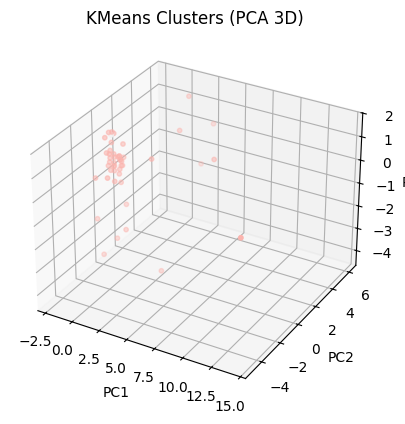

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Z[:, 0], Z[:, 1], Z[:, 2], c=labels, s=10, cmap="Pastel1")
plt.title("KMeans Clusters (PCA 3D)")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
plt.show()

In [53]:
import plotly.express as px
import pandas as pd

df_plot = pd.DataFrame({
    "PC1": Z[:, 0],
    "PC2": Z[:, 1],
    "PC3": Z[:, 2],
    "cluster": labels.astype(str)
})

fig = px.scatter_3d(
    df_plot, x="PC1", y="PC2", z="PC3",
    color="cluster",
    opacity=0.8
)
fig.update_traces(marker=dict(size=3))
fig.update_layout(title="KMeans Clusters (PCA 3D)")
fig.show()

In [54]:
df_pc = pd.DataFrame(Z, columns=["PC1", "PC2", "PC3"], index=df_clean.loc[:, num.union(cat)].index)
df_tagged = df_clean.loc[:, num.union(cat)].loc[df_clean.loc[:, num.union(cat)].index].join(df_pc).assign(cluster=labels)
df_tagged.sort_values("PC2", ascending=False)[:10]

,account_type,acct_status,age,allocated_amt,brkg_type,brokerage_rate,brokerage_type,education_desc,eq_total_assets,eq_vertical,...,peak_asset_val,pincode_affluence,ri_flag,scheme_code,total_products,vertical_disg,PC1,PC2,PC3,cluster
4,THREE_IN_ONE,A,79,189.0,Low,7.0,APRM07007,GRADUATE,0.0,WEALTH,...,8.858123e+07,Very High,Y,Special,12.0,PWM-PHYSICAL,2.701158,6.031067,0.224135,-1
21,THREE_IN_ONE,A,83,749375.0,Low,7.0,PPSN07007,POST GRADUATE,0.0,WEALTH,...,4.438431e+07,Very High,Y,Special,7.0,PWM-PHYSICAL,2.023306,5.461277,-1.448167,-1
17,THREE_IN_ONE,A,70,NaN,High,29.0,MSAVER,POST GRADUATE,0.0,WEALTH,...,1.057839e+08,Very High,Y,Special,5.0,PWM-PHYSICAL,1.335780,4.949270,1.592882,-1
15,THREE_IN_ONE,A,74,429887.0,High,29.0,MSAVER,POST GRADUATE,0.0,WEALTH,...,6.096317e+07,Very High,Y,Special,12.0,PWM-PHYSICAL,1.868271,3.340769,0.694398,-1
20,THREE_IN_ONE,A,68,NaN,Low,10.0,FPRMN1001,POST GRADUATE,0.0,ONLINE,...,7.182258e+07,Very High,Y,Special,15.0,VIRTUAL RM,5.793431,2.450509,0.243545,-1
18,THREE_IN_ONE,A,58,4426.0,High,29.0,MSAVER,POST GRADUATE,0.0,ONLINE,...,1.405889e+07,Very High,Y,Special,6.0,VIRTUAL RM,-0.905119,0.627176,0.077338,-1
5,THREE_IN_ONE,A,38,NaN,Low,15.0,PPSN15015,GRADUATE,0.0,ONLINE,...,8.427340e+05,Very High,Y,Special,7.0,ONLINE,-0.658590,0.539261,-1.911405,-1
1,THREE_IN_ONE,A,82,NaN,Low,10.0,FPRMN1001,OTHERS,0.0,SELECT,...,5.478719e+06,Very High,Y,Special,4.0,VIRTUAL RM,2.874877,0.179942,-4.244560,-1
6,THREE_IN_ONE,A,54,233.0,High,29.0,MSAVER,GRADUATE,NaN,SELECT,...,5.969920e+06,Very High,Y,Special,8.0,VIRTUAL RM,-0.877242,0.178458,0.277771,-1
16,THREE_IN_ONE,A,64,NaN,High,22.0,PRMN22022,POST GRADUATE,0.0,ONLINE,...,5.695794e+06,Very High,Y,Special,13.0,VIRTUAL RM,2.112705,0.163315,0.549750,-1


In [55]:
cluster_summary = df_tagged.groupby("cluster").mean(numeric_only=True)
feature_importance = (cluster_summary.max() - cluster_summary.min()).sort_values(ascending=False)
feature_importance[:10]

income               33.953488
age                   2.234043
PC3                   1.441846
PC1                   1.028550
PC2                   0.487303
experian_score        0.000000
allocated_amt         0.000000
eq_total_assets       0.000000
brokerage_rate        0.000000
no_logins_last_30     0.000000
dtype: float64

In [56]:
silhouette_score(X, labels)

-0.05851554475992345

In [57]:
regressions = []
for feature in num.union(cat):
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    X_feat = df_tagged[[feature]].copy()
    # handle categorical features
    if feature in cat:
        X_feat = pd.get_dummies(X_feat, columns=[feature], drop_first=False)
    # drop rows with NaN
    mask = X_feat.notna().all(axis=1) & df_tagged["PC1"].notna()
    lr.fit(X_feat[mask], df_tagged.loc[mask, "PC1"])
    r2 = lr.score(X_feat[mask], df_tagged.loc[mask, "PC1"])
    regressions.append((feature, r2, lr.coef_))

regressions.sort(key=lambda x: x[1], reverse=True)
for feature, r2, coef in regressions[:10]:
    print(f"Feature: {feature}, R2: {r2:.2f}")

Feature: no_logins_last_30, R2: 0.90
Feature: no_logins_last_60, R2: 0.89
Feature: no_logins_last_90, R2: 0.88
Feature: no_of_logins, R2: 0.82
Feature: brokerage_type, R2: 0.71
Feature: eq_total_assets, R2: 0.70
Feature: brkg_type, R2: 0.46
Feature: mtf_brkg, R2: 0.46
Feature: mtf_rate, R2: 0.46
Feature: brokerage_rate, R2: 0.42


In [58]:
# regression of each feature against PC1 sorted by highest correlation

regressions = []
for feature in num.union(cat):
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    X_feat = df_tagged[[feature]].copy()
    # handle categorical features
    if feature in cat:
        X_feat = pd.get_dummies(X_feat, columns=[feature], drop_first=False)
    # drop rows with NaN
    mask = X_feat.notna().all(axis=1) & df_tagged["PC2"].notna()
    lr.fit(X_feat[mask], df_tagged.loc[mask, "PC2"])
    r2 = lr.score(X_feat[mask], df_tagged.loc[mask, "PC2"])
    regressions.append((feature, r2, lr.coef_))

regressions.sort(key=lambda x: x[1], reverse=True)
for feature, r2, coef in regressions[:10]:
    print(f"Feature: {feature}, R2: {r2:.2f}")

Feature: income_segment, R2: 0.72
Feature: peak_asset_val, R2: 0.69
Feature: mtf_rate, R2: 0.60
Feature: brokerage_type, R2: 0.55
Feature: neq_total_assets, R2: 0.53
Feature: allocated_amt, R2: 0.37
Feature: vertical_disg, R2: 0.37
Feature: eq_vertical, R2: 0.25
Feature: age, R2: 0.25
Feature: education_desc, R2: 0.21


In [59]:
regressions = []
for feature in num.union(cat):
    from sklearn.linear_model import LinearRegression
    lr = LinearRegression()
    X_feat = df_tagged[[feature]].copy()
    # handle categorical features
    if feature in cat:
        X_feat = pd.get_dummies(X_feat, columns=[feature], drop_first=False)
    # drop rows with NaN
    mask = X_feat.notna().all(axis=1) & df_tagged["PC3"].notna()
    lr.fit(X_feat[mask], df_tagged.loc[mask, "PC3"])
    r2 = lr.score(X_feat[mask], df_tagged.loc[mask, "PC3"])
    regressions.append((feature, r2, lr.coef_))

regressions.sort(key=lambda x: x[1], reverse=True)
for feature, r2, coef in regressions[:10]:
    print(f"Feature: {feature}, R2: {r2:.2f}")

Feature: experian_score, R2: 0.71
Feature: occupation_desc, R2: 0.49
Feature: mtf_rate, R2: 0.45
Feature: brokerage_type, R2: 0.37
Feature: income, R2: 0.32
Feature: gender, R2: 0.28
Feature: marital_status, R2: 0.26
Feature: vertical_disg, R2: 0.25
Feature: income_segment, R2: 0.24
Feature: grade, R2: 0.23
